#**Assignment** 1: Simulating a 2D Lennard-Jones Fluid

## Week 1: Computational Soft & Active Matter

In this assignment, you’ll implement a basic molecular dynamics (MD) simulation of a simple fluid



#### Fill in the code where there is an explicit "TO DO" comment
#### You are allowed to change the code as long as the final output remains the same, following cues will be easier though

## 1. The Lennard-Jones Potential
**Background:**

The Lennard-Jones (LJ) potential models the interaction between a pair of neutral atoms or molecules. It has a short-range repulsion (prevents particles from overlapping) and a longer-range attraction (models van der Waals forces). The LJ potential is widely used in simulations of liquids and soft matter.

$$
V(r) = 4\epsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^6 \right]
$$


- $\epsilon$: Depth of the potential well.
- $\sigma$: Finite distance at which the inter-particle potential is zero.
- **Cutoff:** For efficiency, we use a cutoff $r_c$, setting the potential and force to zero for $r > r_c$.



In [50]:
import numpy as np
import matplotlib.pyplot as plt

In [51]:
# Lennard-Jones force and potential
def lennard_jones_force(r_vec, epsilon=1.0, sigma=1.0, r_cutoff=2.5):
    '''
    Calculate the Lennard-Jones force and potential between two particles.
    r_vec: displacement vector between particles (numpy array, shape (2,))
    Returns: force (numpy array), potential (float)
    '''
    r2 = np.dot(r_vec, r_vec)
    r_c2 = r_cutoff**2
    if r2 < 1e-12 or r2 >= r_c2:
        return np.zeros_like(r_vec), 0.0
    inv_r2 = sigma**2 / r2
    inv_r6 = inv_r2 ** 3
    inv_r12 = inv_r6 ** 2
    # Potential
    potential = 4 * epsilon * (inv_r12 - inv_r6)#TO DO
    # Force magnitude (negative derivative of potential)
    force_mag = 24 * epsilon * (2 * inv_r12 - inv_r6) / np.sqrt(r2)#TO DO
    force_vec = force_mag * r_vec / np.sqrt(r2)
    return force_vec, potential

## 2.Periodic Boundary Conditions
**Background:**

To mimic a bulk system (no walls), we use periodic boundaries: particles exiting one side of the box re-enter from the opposite side. This reduces boundary effects and better models infinite systems.




In [52]:
def apply_periodic(pos, box_length):
    """
    Apply periodic boundary conditions by wrapping positions into the primary simulation cell.

    Math:
        For each coordinate: x_wrapped = x mod L, so that x_wrapped ∈ [0, L)

    Parameters:
        pos : np.ndarray
            Array of particle positions, shape (N, dim) or (...).
        box_length : float
            Length of the (cubic) simulation box.

    Returns:
        np.ndarray
            Positions wrapped into [0, box_length) along each axis.
    """
    return pos % box_length #TO DO


def minimum_image(r_vec, box_length):
    """
    Compute the minimum-image displacement vector under periodic boundaries.

    Math:
        Δx = x_j − x_i − L * round((x_j − x_i) / L)
        applied component-wise ensures you always get the shortest separation.

    Parameters:
        r_vec : np.ndarray
            Raw displacement vector(s) between two particles, shape (N, dim) or (dim,).
        box_length : float
            Length of the simulation box.

    Returns:
        np.ndarray
            Displacement(s) shifted into the primary image,
            so that each component lies in [−L/2, L/2).


    """
    return r_vec - box_length * np.round(r_vec / box_length) #TO DO

## 3.Numerical Integration Methods
**Background:**

In molecular dynamics, we advance particles using their positions, velocities, and the forces acting on them.  
Two common numerical schemes are the **Euler method** and the **Velocity Verlet method**.


### **1. Euler Method**

The (explicit) Euler method updates positions and velocities as follows:

$$
\boxed{
\begin{align*}
\mathbf{x}_{t+\Delta t} &= \mathbf{x}_t + \mathbf{v}_t \, \Delta t \\
\mathbf{v}_{t+\Delta t} &= \mathbf{v}_t + \mathbf{a}_t \, \Delta t
\end{align*}
}
$$


---

### **2. Velocity Verlet Method**

Velocity Verlet is a more accurate and stable integrator, especially for molecular dynamics.  
It updates positions and velocities using:

$$
\boxed{
\begin{align*}
\mathbf{x}_{t+\Delta t} &= \mathbf{x}_t + \mathbf{v}_t \Delta t + \frac{1}{2} \mathbf{a}_t \Delta t^2 \\
\mathbf{a}_{t+\Delta t} &= \frac{\mathbf{F}_{t+\Delta t}}{m} \\
\mathbf{v}_{t+\Delta t} &= \mathbf{v}_t + \frac{1}{2} \left( \mathbf{a}_t + \mathbf{a}_{t+\Delta t} \right) \Delta t
\end{align*}
}
$$

---

Implement the update steps for both integrators.  


In [53]:
def euler_step(positions, velocities, forces, dt, box_length):
    """
    Perform one Euler integration step

    Apply periodic boundary conditions to keep particles inside the box.
    """
    #Update positions using the Euler method:
    positions_new = positions + velocities * dt

    # TODO: Wrap positions into the simulation box:
    positions_new = apply_periodic(positions_new, box_length)

    # TODO: Update velocities using the Euler method:
    velocities_new = velocities + forces * dt

    # TODO: return the new positions and velocities
    return positions_new, velocities_new




In [54]:
def velocity_verlet_step(positions, velocities, forces, dt, box_length, **force_args):
    """
    Perform one Velocity Verlet integration step.

    Apply periodic boundary conditions after updating positions.
    """
    # TODO: Update positions using Velocity Verlet formula:
    positions_new = positions + velocities * dt + 0.5 * forces * dt**2

    # TODO: Wrap positions into the simulation box:
    positions_new = apply_periodic(positions_new, box_length)

    # TODO: Compute new forces at the updated positions:
    forces_new, _ = compute_forces(positions_new, box_length, **force_args)

    # TODO: Update velocities using the Velocity Verlet formula:
    velocities_new = velocities + 0.5 * (forces + forces_new) * dt

    # TODO: return positions_new, velocities_new, forces_new

    return positions_new, velocities_new, forces_new



## 4. Initialization of the System
**Background:**

We need to carefully set up initial positions (to avoid overlaps) and velocities (matching a target temperature, using a random Gaussian distribution).




In [55]:
#NO CHANGES REQUIRED IN THIS SECTION, RUN THIS
def initialize_system(N, box_length, temperature):
    """
    Places N particles on a square grid inside the box,
    adds small random displacements, and assigns velocities
    based on the desired temperature.
    """
    # Step 1: Arrange particles on a square grid
    n_side = int(np.ceil(np.sqrt(N)))           # Particles per row/column
    spacing = box_length / n_side               # Grid spacing
    positions = []

    for i in range(N):
        col = i % n_side
        row = i // n_side
        x = (col + 0.5) * spacing
        y = (row + 0.5) * spacing
        positions.append([x, y])

    positions = np.array(positions[:N])

    # Add small random displacement to avoid perfect grid symmetry
    positions += 0.1 * spacing * (np.random.rand(N, 2) - 0.5)

    # Initialize velocities from a normal distribution
    velocities = np.random.normal(0, np.sqrt(temperature), (N, 2))

    # Shift velocities to remove net momentum (center of mass velocity = 0)
    velocities -= np.mean(velocities, axis=0)

    return positions, velocities
def compute_forces(positions, box_length, epsilon=1.0, sigma=1.0, r_cutoff=2.5):
    N = len(positions)
    forces = np.zeros_like(positions)
    total_potential = 0.0
    for i in range(N):
        for j in range(i + 1, N):
            r_vec = minimum_image(positions[j] - positions[i], box_length)
            f_ij, pot = lennard_jones_force(r_vec, epsilon, sigma, r_cutoff)
            forces[i] += f_ij
            forces[j] -= f_ij
            total_potential += pot
    return forces, total_potential

## 5. Energy Conservation in Simulations
**Background:**

Physical systems conserve total energy (if isolated). Good integration schemes should keep energy nearly constant, aside from small numerical errors.

**Learning Objective:** Calculate the total kinetic and potential energy.


In [56]:
# IMPLEMENT: Energy calculation, returrn kinetic + potential energy for unit mass
def total_energy(velocities, potential):
    kinetic= 0.5 * np.sum(velocities**2) #TO DO
    total= kinetic + potential #TO DO
    return total

## 6. Running the Simulation
NO TO DO here, just run these blocks, implementing the above functions

Simulate $N=25$ particles in a $L=7.0$ box at $T=1.0$ using both Euler and Velocity Verlet integration, record the energy, and compare results.



In [57]:
# ------------------------
# Euler Simulation Block
# ------------------------

# Simulation parameters
N = 25
L = 7.0
T = 1.0
dt = 0.005
steps = 10000

# Initialize the system
pos_e, vel_e = initialize_system(N, L, T)

# Compute initial forces and potential
forces_e, pot_e = compute_forces(pos_e, L)

# Run the simulation
energy_e = []
for step in range(steps):
    pos_e, vel_e = euler_step(pos_e, vel_e, forces_e, dt, L)
    forces_e, pot_e = compute_forces(pos_e, L)
    energy_e.append(total_energy(vel_e, pot_e))

In [58]:
# -----------------------------
# Velocity Verlet Simulation Block
# -----------------------------

# Simulation parameters
N = 25
L = 7.0
T = 1.0
dt = 0.005
steps = 10000

# Initialize the system
pos_v, vel_v = initialize_system(N, L, T)

# Compute initial forces and potential
forces_v, pot_v = compute_forces(pos_v, L)

# Run the simulation
energy_v = []
for step in range(steps):
    pos_v, vel_v, forces_v = velocity_verlet_step(pos_v, vel_v, forces_v, dt, L)
    forces_v, pot_v = compute_forces(pos_v, L)
    energy_v.append(total_energy(vel_v, pot_v))

## 7. Plotting Energy Conservation
NO TO DO here, just run these blocks, implementing the above functions


**Learning Objective:** Interpret energy drift and compare the performance of Euler vs. Velocity Verlet.
import matplotlib.pyplot as plt
import numpy as np





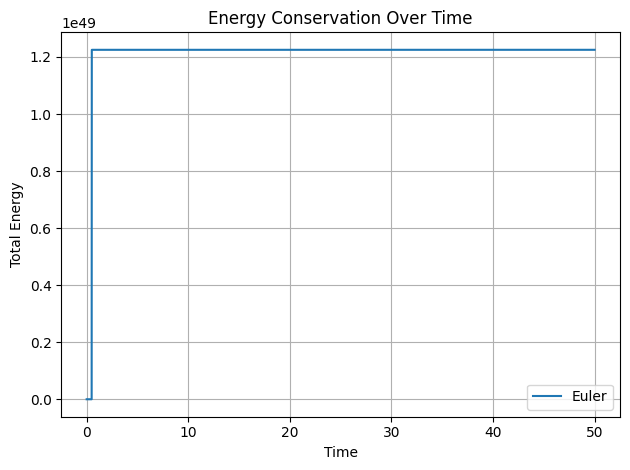

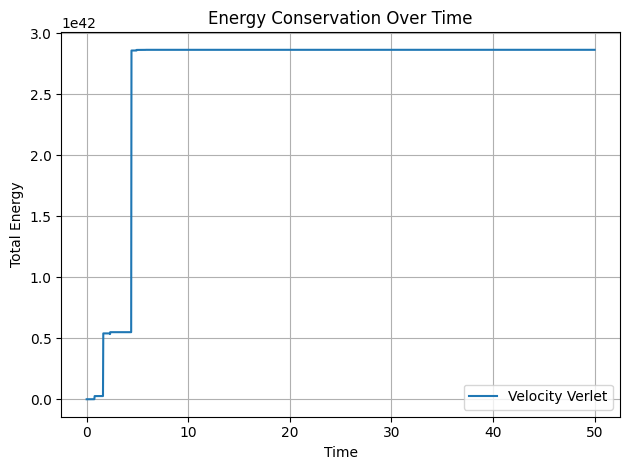

In [59]:
def plot_energy(energies, dt, label=None):
    """
    Plots total energy vs simulation time.
        """
    times = np.arange(len(energies)) * dt
    plt.plot(times, energies, label=label)
    plt.xlabel("Time")
    plt.ylabel("Total Energy")
    plt.title("Energy Conservation Over Time")
    if label:
        plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot both simulations
plot_energy(energy_e, dt, label="Euler")
plot_energy(energy_v, dt, label="Velocity Verlet")


## 9. Discussion
**Type your answers below:**

- Which integrator conserves energy better? Why?

The Velocity Verlet integrator conserves energy better than Euler method. Because Velocity Verlet is time-reversible and symplectic, which helps it preserve the total energy of the system over long simulations. Whereas, Euler is an explicit method that accumulates error over time, leading to energy drift and inaccurate dynamics.
